# ⭐ 1.

### 🔴 Imports

In [1]:
# import the necessary packages
import numpy as np
import imutils
from imutils.video import VideoStream
from imutils.video import FileVideoStream
import time
import cv2
import time
import matplotlib.pyplot as plt
from tracker_counter import *
from PIL import Image
from datetime import datetime


import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

### 🔴 Load Classifier

TODO: Find better classifiers for classifying moving faces </br>
https://github.com/J-Douglas/Face-Mask-Detection

In [2]:
choose = ['YOUTUBE', 'DENSENET']

classifier = 'YOUTUBE'

if classifier == 'YOUTUBE':
    classifier = tf.keras.models.load_model('CLASSIFIERS/youtube_20epoch.h5')

elif classifier == 'DENSENET':
    classifier = tf.keras.models.load_model('densenet12.h5')

### 🔴 Load Detector

In [3]:
choose = ['CAFFE', 'YOLO', 'OTHER']

detector = 'CAFFE'

if detector == 'CAFFE':
    # load our serialized face detector model from disk
    prototxtPath = r"DETECTORS/ssd_caffee/deploy.prototxt" # configurations file 
    weightsPath = r"DETECTORS/ssd_caffee/res10_300x300_ssd_iter_140000.caffemodel" # weights file
    detector = cv2.dnn.readNet(prototxtPath, weightsPath) # load saved model
    
elif detector == 'YOLO':
    from yoloface import face_analysis
    detector=face_analysis()    #  Auto Download a large weight files from Google Drive.
                                #  only first time.
                                #  Automatically  create folder .yoloface on cwd.
elif detector == 'OTHER':
    pass

### 🔴 Run the System

In [4]:
def detect_and_classify(frame, detector, classifier):
    # detect faces in frame and perform mask classification
    # TODO: Change RGB Tuple
    # turn frame into blob (essentially preprocessing: 1. mean subtraction, 2. scaling, 3. optionally channel swapping)
    RGB = (104.0, 177.0, 123.0) # Consider changing. Read the following under "Deep Learning and Mean Subtraction for intuition: https://pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
    pixels = 224
    blob = cv2.dnn.blobFromImage(frame, scalefactor=1.0, size=(pixels, pixels), mean=RGB)
    
    '''
    DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION 
    DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION 
    DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION DETECTION 
    '''
    
        
    '''
    # Unique code for YOLO face detector
    
    
    _, box, confidence = detector.face_detection(frame_arr=frame,frame_status=True,model='tiny')
    #output_frame = detector.show_output(frame,box,frame_status=True)
    num_of_detections = len(box)
    
    # initialise list of faces, their locations, list of predictions for our mask classifier, rectangles list for tracking
    faces = []
    locs = []
    preds = []
    rects = [] 

    
    # loop over all face detections
    for i in range(num_of_detections):
        
        # Live Counter
        num_of_masked = 0
        num_of_unmasked = 0
        num_of_uncertain = 0
        

        # filter out weak detections by ensuring the confidence is  greater than the minimum confidence
        # TODO: optimise this number
        if confidence[i] > 0.:
            
            # compute the (x, y)-coordinates of the bounding box for the object 
            rect = np.array(box[i])
            rect[2], rect[3] = rect[0]+rect[3], rect[1]+rect[2] # change to (startX, startY, endX, endY) format
            rects.append(rect.astype('int'))
            (startX, startY, endX, endY) = rect.astype("int")
    
    # and the rest is the same
    
    '''
    
    
    '''
    TODO: Understand
    pass the blob through the network and obtain the face detections in the form of a blob. Current shape: (1, 1, 200, 7).
    1st dim: ?
    2nd dim: ?
    3rd dim: number of detections
    4th dim: (?, ?, confidence, startX %, startY %, endX %, endY %)
    The output is a 200x7 "array of heatmaps", the probability of a face being in location x, y. 
    I think 200 (the third value) is the number of face detections. I.e. 200 faces where detected each with a different probability of being a face. 
    '''
    detector.setInput(blob)
    detections = detector.forward()
    num_of_detections = detections.shape[2]

    

    # initialise list of faces, their locations, list of predictions for our mask classifier, rectangles list for tracking
    faces = []
    locs = []
    preds = []
    rects = []
    
    # loop over all face detections
    for i in range(num_of_detections):
        
        # Live Counter
        num_of_masked = 0
        num_of_unmasked = 0
        num_of_uncertain = 0
        
        # extract the confidence (probability) in the detection
        # The 1st and 2nd seem to be either 0 or 1. 
        # The last 4 are boundaries of box respectively: startX %, startY %, endX %, endY %. For example 30% of width to 60% of width and 10% of height to 40% of height of image. 
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is  greater than the minimum confidence
        if confidence > 0.3:
            
            # compute the (x, y)-coordinates of the bounding box for the object 
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            rects.append(box.astype('int'))
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of the frame 
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # Extract Face 
            face = frame[startY:endY, startX:endX]                          # 1. extract the face region of interest (ROI) 
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)                    # 2. convert it from BGR to RGB channel ordering 
            face = cv2.resize(face, (224, 224))                             # 3. resize it to 224x224 
            face = tf.keras.preprocessing.image.img_to_array(face)          # 4. preprocess it for the mask classifier
            face = tf.keras.applications.mobilenet_v2.preprocess_input(face)

            # append face and bounding box to lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference make batch predictions on *all* faces at the same time rather than one-by-one predictions in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = classifier.predict(faces, batch_size=32)
  


    return locs, preds, rects

In [5]:
import math
from random import randrange

class TrackerCounter:
    
    people_count = 0
    mask_count = 0
    nomask_count = 0
    uncertain_count = 0
    
    def __init__(self):
       
        # Store the center positions of the objects
        # Form -->      id: [cx, cy, has_been_top_80%, has_been_tracked_at_bottom_20%, most_recent_label]
        self.center_points = {}
        # Keep the count of the IDs
        # each time a new object id detected, the count will increase by one
        self.id_count = 0


    def update(self, objects_rect, label_probs, w, h, sensitivity=100):
        
        # TODO: change name: sensitivity. Should be the opposite bc the higher the sensitivity the less sensitive it is to false positives.
        # TODO: change sensitivity to s = (w + h) / 14 to be a function of the width / height of the frame (once you access them)
    
        '''
        object_rect: List of object coordinates in the form [(xstart1, ystart1, xend1, yend1), (xstart2, ystart2, xend2, yend2), ...]
    
        
        Sensitivity: Added by me
        - Sensitivity determines how far the detection has to be from the old one to be considered a new object. 
        - If sensitivity is too low we might get false positives when an object is moving. 
        - It also depends on the amount of pixels so needs different value when resolution changes.
        '''
            
        # Objects boxes and ids
        objects_bbs_ids = []
        # Entries for dataset
        
        
        # Loop through all faces and their labels
        for rect, prob in zip(objects_rect, label_probs):
            xstart, ystart, xend, yend = rect
            # Get center point of new object
            cx = (xstart + xend) // 2
            cy = (ystart + yend) // 2 
            
            
            # Find out if that object has been detected already
            same_object_detected = False
            for face_id, pt in self.center_points.items():
                # find hypotenuse form
                dist = math.hypot(cx - pt[0], cy - pt[1])
                
                # if euclidean distance is lower than sensitivity it keeps the same object id 
                if dist < sensitivity:
                    self.center_points[face_id][0] = cx      # update center x
                    self.center_points[face_id][1] = cy      # update center y 
                    
                    # to average over labels
                    frames_to_avg_over = 10
                    if len(pt[4]) < frames_to_avg_over:
                        self.center_points[face_id][4].append(prob)
                    # if youve already got 10 probabilities then replace one at random (because the code for cycling through them one by one seems too complex in this case)
                    else: 
                        self.center_points[face_id][4][randrange(frames_to_avg_over)] = prob # update to latest label
                    

                    objects_bbs_ids.append([xstart, ystart, xend, yend, face_id])
                    same_object_detected = True 
                
                    break
                
            
            # New object is detected we assign the ID to that object
            if same_object_detected == False:
                self.id_count += 1
                self.center_points[self.id_count] = [cx, cy, False, False, [prob]]
                
                
                
                # Cleanup ting
                objects_bbs_ids.append([xstart, ystart, xend, yend, self.id_count])
                
                    
        # Clean the dictionary by center points to remove IDS not used anymore
        # TODO: consider running this every 5 frames to fix disappearing face = new face problem.
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center
        
        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        
        
        
        # People counter 
        for face_id, pt in self.center_points.items():
            # Note if object has been in the top 80% of the frame
            if pt[0] > line_L:
                self.center_points[face_id][2] = True
            
            # Note if the object 
            # 1. has been detected after the boundary
            # 2. has been detected before the boundary (can remove this condition, it is just to ensure that someone who appears from the bottom is not counted) and
            # 3. has never been counted before 
            # Then update it to having been counted and increase people count by 1 
            # NB: pt[0] = xcenter, pt[1] = ycenter
            if (pt[0] < line_L) and (pt[2] == True) and pt[3] == False:
                self.center_points[face_id][3] = True
                self.people_count += 1 
                
                
                div = 3 # the larger div is the smaller the perpetrator frame will be 
                

                # labeled count

                avg_prob = np.mean(pt[4])

                if avg_prob > 0.5 + uncertain_interval:
                    self.mask_count += 1
                    
                    # TODO: Only for testing, remove 
                    # Save and display image of masked person
                    print(f'MASK ({current_time})')
                    # Catch exception where face is moving too fast and towards bottom left and perpetrator[0] or perpetrator[1] (width or height or both) ends up being 0.
                    perpetrator=frame[0:h, 0:line_L + w//5]
                    perpetrator = cv2.cvtColor(perpetrator, cv2.COLOR_BGR2RGB)
                    perpetrator = Image.fromarray(perpetrator, 'RGB')
                    plt.imshow(perpetrator)
                    plt.show()
                    
                elif avg_prob < -0.5 - uncertain_interval:
                    self.nomask_count += 1
                    
                    # Save and display image of unmasked person
                    print(f'NO MASK ({current_time})')
                    # Catch exception where face is moving too fast and towards bottom left and perpetrator[0] or perpetrator[1] (width or height or both) ends up being 0.
                    perpetrator=frame[0:h, 0:line_L + w//5]
                    perpetrator = cv2.cvtColor(perpetrator, cv2.COLOR_BGR2RGB)
                    perpetrator = Image.fromarray(perpetrator, 'RGB')
                    plt.imshow(perpetrator)
                    plt.show()

                    #cv2.imshow('perpetrator', perpetrator)
                    
                else:
                    self.uncertain_count += 1
                    
                    # Save and display image of potentially unmasked person
                    print(f'UNCERTAIN ({current_time})')
                    # Catch exception where face is moving too fast and towards bottom left and perpetrator[1] (the height of the image) ends up being 0. If it happens a lot the line can be moved above 80%
                    perpetrator=frame[0:h, 0:line_L + w//5]
                    perpetrator = cv2.cvtColor(perpetrator, cv2.COLOR_BGR2RGB)
                    perpetrator = Image.fromarray(perpetrator, 'RGB')
                    plt.imshow(perpetrator)
                    plt.show()
                                                

                        
                        #perpetrator.save('perpetrator.png')
                        
        
        return objects_bbs_ids





In [6]:
# initialise the video stream
#vs = VideoStream(src=0).start()
#vs = FileVideoStream('video_test/video3_15fps.mp4').start()

MASK (2022-07-30 10:58:31)


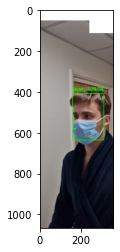

NO MASK (2022-07-30 10:58:35)


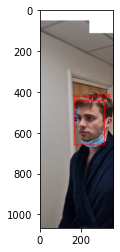

NO MASK (2022-07-30 10:58:39)


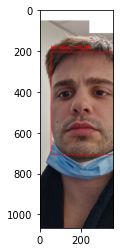

NO MASK (2022-07-30 10:58:44)


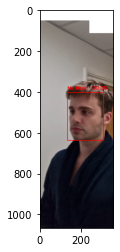

MASK (2022-07-30 10:58:48)


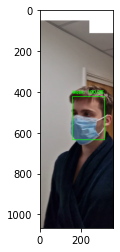

NO MASK (2022-07-30 10:58:53)


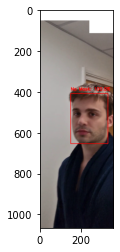

MASK (2022-07-30 10:58:58)


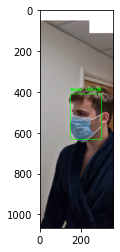

NO MASK (2022-07-30 10:59:01)


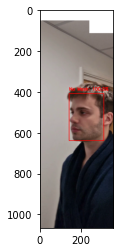

NO MASK (2022-07-30 10:59:04)


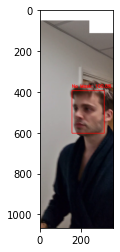

UNCERTAIN (2022-07-30 10:59:08)


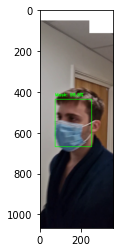

AttributeError: 'NoneType' object has no attribute 'shape'

In [7]:
vs = FileVideoStream('video_test/video3_15fps.mp4').start()

# Instantiate tracker / counter
tracker=TrackerCounter()

# Initialise total tracked faces to 0 
idd=0 

# Count fps initialise
fps_start_time = 0
fps = 0

# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it to have a maximum width of 400 pixels
    # NB: cv2.resize lets you choose height and width, imutils.resize only width but preserves ratio
    frame = vs.read()
    
    # count fps
    fps_end_time = time.time()
    time_diff = fps_end_time - fps_start_time
    fps = int(1/time_diff)
    fps = f'FPS: {fps}'
    fps_start_time = fps_end_time

    
    #frame = cv2.resize(frame, dsize=(x, y)) 
    frame = imutils.resize(frame, width=600)
    h, w = frame.shape[:2] # used in detect_and_classify also
    
    # Display current time
    line_L = int(0.4*w)
    current_time = str(datetime.now())[:-7]
    
    # Display Background Boxes
    scale = 0.030 # this value can be from 0 to 1 (0,1] to change the size of the text relative to the image
    font_stats = min(w,h)/(25/scale)
    yy = int(font_stats*35)
    
    box1start = np.array((0, 0))
    box1end = np.array((int(0.40*w), yy*2))
    box2start = np.array((int(0.40*w), 0))
    box2end = np.array((w, int(yy*4.5)))
    
    
    # Background boxes 1, 2, 3 TODO: consider border instead of diff colours 
    cv2.rectangle(frame, pt1=box1start, pt2=box1end, color=(255, 255, 255), thickness=-1)
    cv2.rectangle(frame, pt1=box2start, pt2=box2end, color=(255, 255, 255), thickness=-1)


    
    x = 10
    y = 100
    
    # Detect and Classify for each frame
    locs, preds, rects = detect_and_classify(frame, detector, classifier)

    '''
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS 
    VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS VISUALS 
    '''
    
    label_probs = []
    # Live Counter
    num_of_masked = 0
    num_of_unmasked = 0
    num_of_uncertain = 0
    
    # loop over face locations and mask predictions
    for box, pred in zip(locs, preds):
        
        # unpack the bounding box and predictions
        startX, startY, endX, endY = box
        mask, no_mask = pred

        # 1. Determine the class label 2. Add colour (BGR)
        uncertain_interval = 0.1 # 0.1 is 10% so 40-60 
        
        if mask >= 0.5 + uncertain_interval:
            label = 'Mask'
            colour = (0, 255, 0)
            num_of_masked +=1
            label_probs.append(mask)
            
        elif no_mask >= 0.5 + uncertain_interval:
            label = 'No Mask'
            colour = (0, 0, 255)
            num_of_unmasked +=1
            label_probs.append(-no_mask)
            
        elif (mask >= 0.5) and (mask <= 0.5 + uncertain_interval):
            label = 'Uncertain'
            colour = (0, 255, 255)
            num_of_uncertain +=1
            # for tracker_counter to average over 
            label_probs.append(mask)
            
        elif (no_mask >= 0.5) and (no_mask <= 0.5 + uncertain_interval):
            label = 'Uncertain'
            colour = (0, 255, 255)
            num_of_uncertain +=1
            # for tracker_counter to average over 
            label_probs.append(-no_mask)
        
        # probability and text to display
        probability = max(mask, no_mask) * 100
        label_text = f'{label}: {probability:.1f}%'
        
        # 'probability' for tracker_counter to average over 
        
        
        # 1. Display label  
        cv2.putText(img=frame, text=label_text, org=(startX, startY - 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=colour, thickness=2)
        # 2. Display bounding box
        cv2.rectangle(img=frame, pt1=(startX, startY), pt2=(endX, endY), color=colour, thickness=2)
        

    '''
    TRACKING / COUNTING TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING 
    TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING 
    TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING TRACKING 
    '''
    
    
    # YOUTUBE https://pysource.com/2021/01/28/object-tracking-with-opencv-and-python/
    # boxes_ids contains [object1_info, object2_info, ...] where object1_info = [Xstart, Ystart, Xend, Yend, id_of_object]
    boxes_ids = tracker.update(rects, label_probs, w, h, sensitivity=(w + h / 14))
        
    # for all objects
    for box_id in boxes_ids: 
        Xstart, Ystart, Xend, Yend, idd = box_id
        
        # VISUALS        
        # Text
        # ID of face (TODO: get rid of this eventually)
        cv2.putText(img=frame, text=f'Face {idd}', org=(Xstart, Ystart-40), fontScale=1.4, fontFace=cv2.FONT_HERSHEY_PLAIN, color=(155, 149, 24), thickness=2)
    
    y=15
    # TODO: Get rid of this eventually.Think of potential use cases
    cv2.putText(img=frame, text=current_time, org=(box1start[0] + box1start[0]//14, yy), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=2)
    cv2.putText(img=frame, text=fps, org=(box1start[0] + box1start[0]//14, int(yy*1.8)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=2)
    
    # Draw Line of people count
    cv2.line(img=frame, pt1=(line_L, y), pt2=(line_L, h), color=(45, 174, 102), thickness=5) 
    
    # Live Counter

    
    cv2.putText(img=frame, text=f'People Count: {tracker.people_count}', org=(box2start[0] + box2start[0]//15, yy), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_stats, color=(0, 0, 0), thickness=2)
    percent_masked = 0
    percent_unmasked = 0
    percent_uncertain = 0
    if tracker.people_count != 0:
        percent_masked = np.round(tracker.mask_count / tracker.people_count * 100, 1) 
        percent_unmasked = np.round(tracker.nomask_count / tracker.people_count * 100, 1) 
        percent_uncertain = np.round(tracker.uncertain_count / tracker.people_count * 100, 1) 
    cv2.putText(img=frame, text=f'Masked:       {tracker.mask_count} ({percent_masked}%)', org=(box2start[0] + box2start[0]//15, yy*2), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_stats, color=(0, 155, 0), thickness=2)
    cv2.putText(img=frame, text=f'Unmasked:    {tracker.nomask_count} ({percent_unmasked}%)', org=(box2start[0] + box2start[0]//15, int(yy*3)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_stats, color=(0, 0, 155), thickness=2)
    cv2.putText(img=frame, text=f'Uncertain:     {tracker.uncertain_count} ({percent_uncertain}%)', org=(box2start[0] + box2start[0]//15, int(yy*4)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_stats, color=(0, 155, 155), thickness=2)

    '''
    END
    '''
    box1start = np.array((0, 0))
    box1end = np.array((int(0.40*w), int(0.10*h)))
    box2start = np.array((int(0.40*w), 0))
    box2end = np.array((w, int(0.20*h)))    
            
    # Show the output frame in real-time
    cv2.imshow("Frame", frame)

    # Terminate if `q` is pressed. waitKey(0): keeps image still until a key is pressed. waitKey(x) it will wait x miliseconds each frame
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break


        
# TODO: run classifier multiple times on the same tracked face to average out results. More robust classification. 
# TODO: Alert when someone goes in with no mask or uncertain and save and display their face over the video (perhaps on the right hand side) for security to go get them
# TODO: export all collected data to csv here? 
# TODO: also add date and time for maybe all the detections or for when the programme ran 
        
# # Cleanup
vs.stop()
cv2.destroyAllWindows()


In [ ]:
vs.stop()